In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#1. Perspective Projection Correction
Correct the source image in reference with the destination image

In [ ]:
#Download the images
!gdown --id '1O3_PJ9bTKJbf89b2_SUEuFkbTXrmCsrK' --output book1.jpg
!gdown --id '1Qh1Ydq9bJezPfGvdFCnF-9iN5Yp_Kv1r' --output book2.jpg

Downloading...
From: https://drive.google.com/uc?id=1O3_PJ9bTKJbf89b2_SUEuFkbTXrmCsrK
To: /content/book1.jpg
100% 155k/155k [00:00<00:00, 1.37MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qh1Ydq9bJezPfGvdFCnF-9iN5Yp_Kv1r
To: /content/book2.jpg
100% 153k/153k [00:00<00:00, 1.36MB/s]


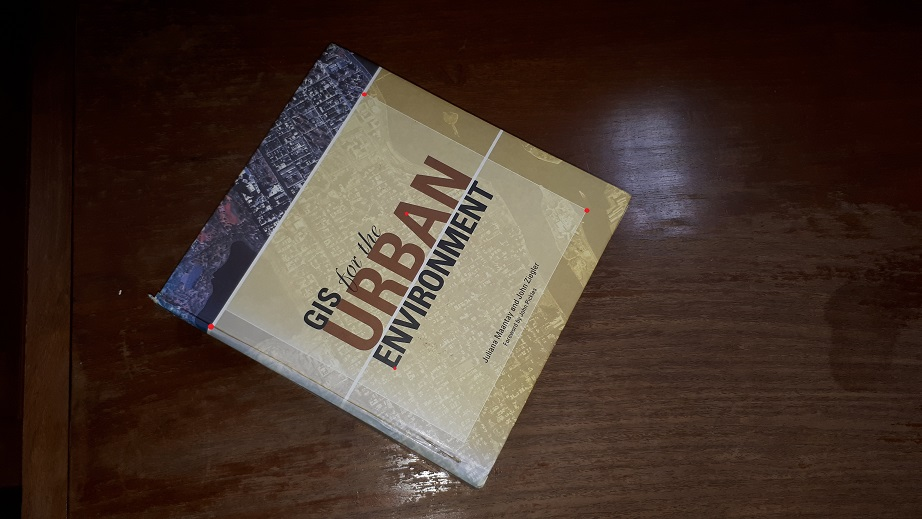

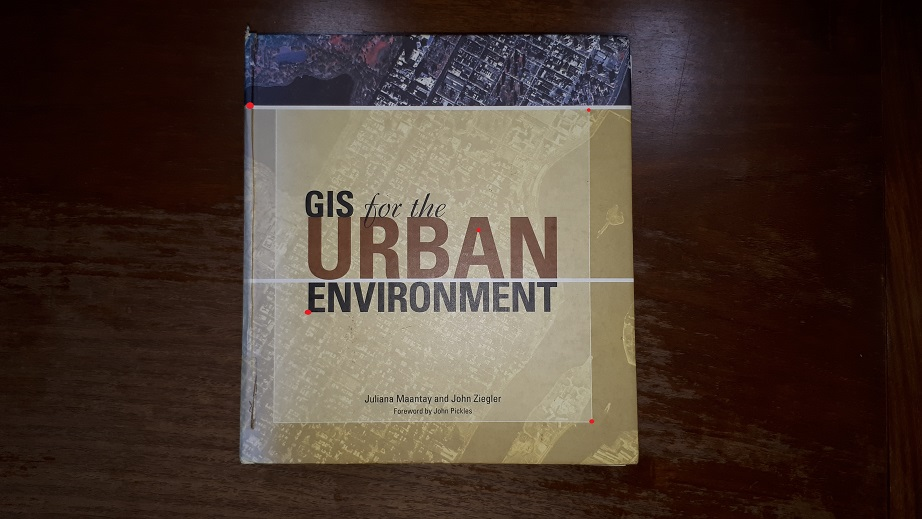

In [ ]:
#Read the source Image
im_src = cv2.imread('book1.jpg')
#Read the destination Image
im_dst = cv2.imread('book2.jpg')
#display the images
cv2_imshow(im_src)
cv2_imshow(im_dst)

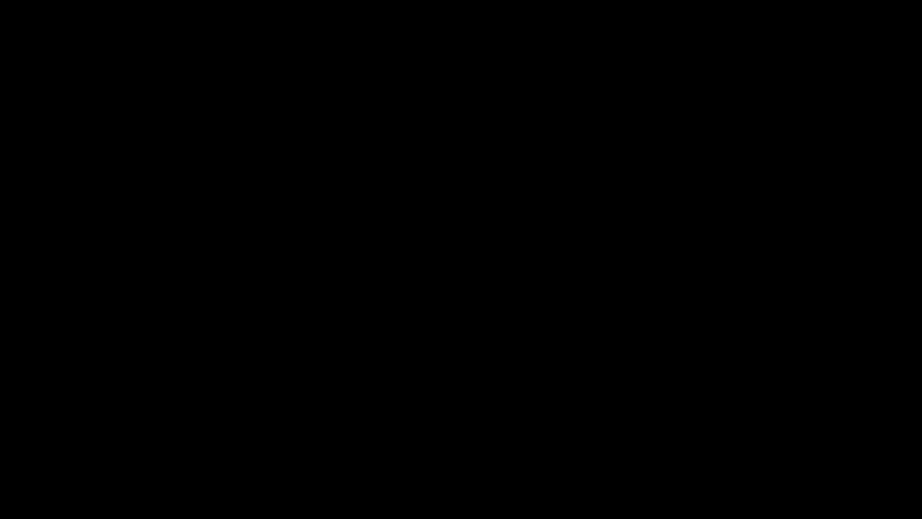

In [ ]:
#Identify the coordinates of the points marked in red color in the source image
pts_src = np.array([[1053,1633], [1821,469], [2033,1064],[1969,1838],[2933,1050]])
#Identify the coordinates of the points marked in red color in the destination image
pts_dst = np.array([[1247,527],[2941,549],[2393,1148],[1541,1556],[2957,2105]])
#Calculate the homography
h, status = cv2.findHomography(pts_src, pts_dst)
#Wrap the images
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
#display the corrected image
cv2_imshow(im_out)

#2. Image Stitching
Stitch first two images into one from the image dataset

In [ ]:
# download the images (6 Images)
!gdown --id '1CDPf0zhlVYR7Fd1vSL22A10KSLb3JeCl' --output site1.jpg
!gdown --id '1b7EZ_nLLUx_sjjHlPGxW4kaXRsZFVDzu' --output site2.jpg
!gdown --id '1KQ2xVihVNdUNtHnurStDbtD4L6AbhPZL' --output site3.jpg
!gdown --id '1gu3C0ZUMGcfRjyZHZbte_gesbUuBpW0S' --output site4.jpg
!gdown --id '1zHAtikO9dVHpLPJ-KQPdvKEC-wLB1hHM' --output site5.jpg
!gdown --id '1RNCdBF9a4fIdcyPvjelyx7dsheLgRoaQ' --output site6.jpg

# use openCV to read the original image
img_1 = cv2.imread('site1.jpg')
img_2 = cv2.imread('site2.jpg')
img_3 = cv2.imread('site3.jpg')
img_4 = cv2.imread('site4.jpg')
img_5 = cv2.imread('site5.jpg')
img_6 = cv2.imread('site6.jpg')

#Resize images for convenience
def resizeimg (img):
  img_1 = cv2.resize(img, (int(img.shape[1]*0.5),int(img.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
  return img_1 
img_1 = resizeimg(img_1)
img_2 = resizeimg(img_2)
img_3 = resizeimg(img_3)
img_4 = resizeimg(img_4)
img_5 = resizeimg(img_5)
img_6 = resizeimg(img_6)

#Display the images
cv2_imshow(img_1)
cv2_imshow(img_2)
cv2_imshow(img_3)
cv2_imshow(img_4)
cv2_imshow(img_5)
cv2_imshow(img_6)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Write a function named 'imagestitcher' that can stitch two images
def imagestitcher (img1, img2):
    
    #Convert input images to grayscale
    img1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
    
    #SIFT Feature detection
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    #Feature matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good = []
    for m in matches:
        if (m[0].distance < 0.5*m[1].distance):RFSADFAFAS
            good.append(m)
    matches = np.asarray(good)
    
    #Homography calculation using RANSAC
    if (len(matches[:,0]) >= 4):
        src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    else:
        raise AssertionError('Can’t find enough keypoints.')
    
    #Image Stitching
    #dst = cv2.warpPerspective(img_1,H,((img_1.shape[1] + img_2.shape[1]), img_2.shape[0])) #wraped image
    dst = cv2.warpPerspective(img_1,H,((int(img_1.shape[1]*0.5) + img_2.shape[1]) , img_2.shape[0])) #wraped image
    dst[0:img_2.shape[0], 0:img_2.shape[1]] = img_2 #stitched image
    return dst

IndentationError: ignored

In [ ]:
#In case your Open CV version do not support SIFT
!pip install opencv-contrib-python==4.4.0.46

In [ ]:
#Stitch the first two site images into one and display
stitched_img = imagestitcher(img_1,img_2)
cv2_imshow(stitched_img)

#3. Panorama creation
Create a panorama combining all 6 images

In [ ]:
#Stitch all 6 images to make a Panorama

images = [img_1,img_2,img_3,img_4,img_5,img_6]
stitcher = cv2.Stitcher_create()
(status, pano) = stitcher.stitch(images)

if status == 0:
    # display the output stitched image to our screen
    cv2_imshow(pano)
# otherwise the stitching failed, likely due to not enough keypoints)
# being detected
else:
    print("[INFO] image stitching failed ({})".format(status))
# Display the panorama image